<AxesSubplot:>

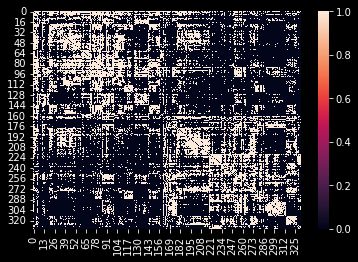

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('data/sub-CON01_ses-preop.csv',header=None)
df = (df > 0).astype(int)
sns.heatmap(df)

In [2]:
# generate synthetic data

x = [0.1]
y = [0.2]
for _ in range(10):
    new_x = x[-1] * (3.78 - 3.78 * x[-1])
    new_y = y[-1] * (3.77 - 3.77 * y[-1])
    x.append(new_x)
    y.append(new_y)

# for _ in range(2000000):
for _ in range(20000):
    new_x = x[-1] * (3.78 - 3.78 * x[-1])
    new_y = y[-1] * (3.77 - 3.77 * y[-1] - 0.8 * x[-10])
    x.append(new_x)
    y.append(new_y)

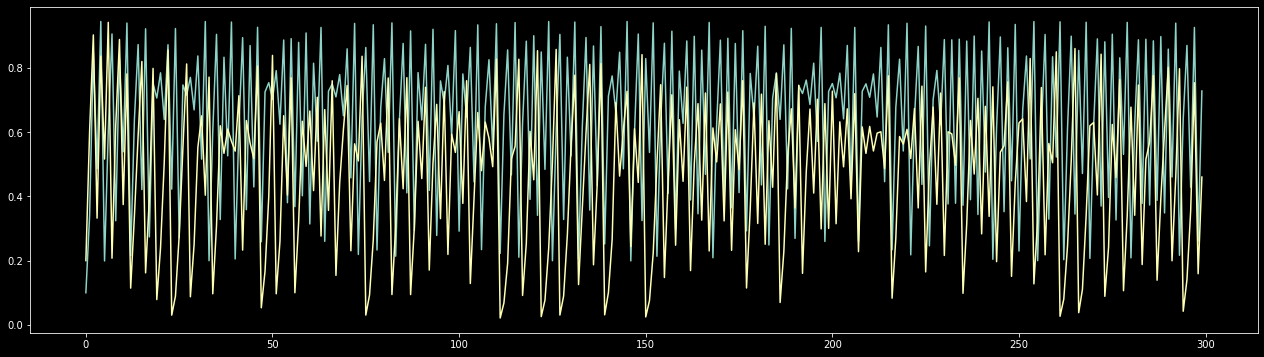

In [3]:
plt.figure(figsize=(22, 6))

plt.plot(x[:300])
plt.plot(y[:300])

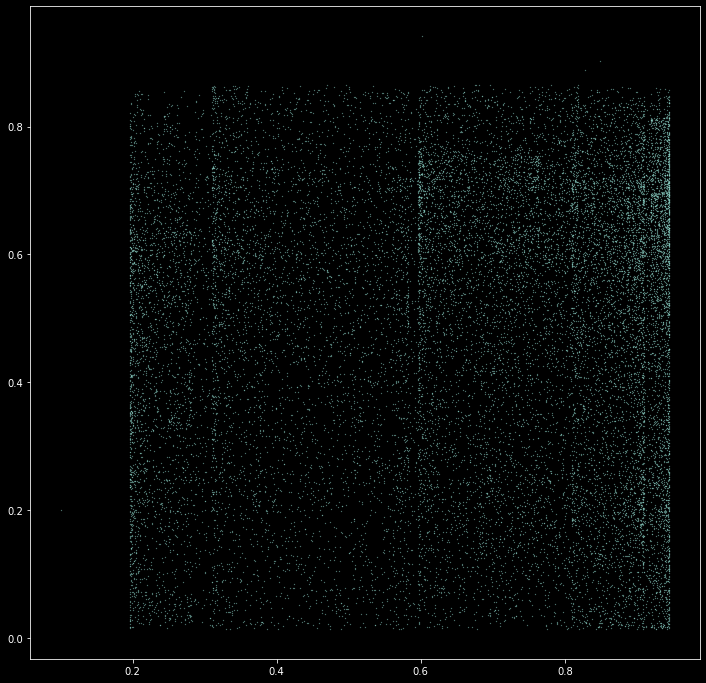

In [4]:
plt.figure(figsize=(12, 12))

# plt.plot(x[:300], y[:300], linewidth=0.3)
plt.scatter(x, y, s=0.05)


In [5]:
# correlation
np.corrcoef(x, y)[0, 1]

0.04771504806631682

# Reservoir computing

In [6]:
from easyesn import PredictionESN


Using Numpy backend.


ModuleNotFoundError: No module named 'scipy.sparse.linalg.eigen.arpack'; 'scipy.sparse.linalg.eigen' is not a package